In [1]:
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle

#### Getting the data

In [2]:
algorithm = 'louvain' # 'louvain' or 'infomap'

In [3]:
output_path = f"../../results/{algorithm}_communities"

before_comms = pickle.load(open(os.path.join(output_path, 'before_comms.pickle'), 'rb'))
during_comms = pickle.load(open(os.path.join(output_path, 'during_comms.pickle'), 'rb'))
after_comms = pickle.load(open(os.path.join(output_path, 'after_comms.pickle'), 'rb'))

In [4]:
# load the community composition
output_path = f"../../results/{algorithm}_communities/comms_composition"

before_community_composition = pickle.load(open(os.path.join(output_path, 'before_community_composition.pickle'), 'rb'))
during_community_composition = pickle.load(open(os.path.join(output_path, 'during_community_composition.pickle'), 'rb'))
after_community_composition = pickle.load(open(os.path.join(output_path, 'after_community_composition.pickle'), 'rb'))

before_parties = pickle.load(open(os.path.join(output_path, 'before_parties.pickle'), 'rb'))
during_parties = pickle.load(open(os.path.join(output_path, 'during_parties.pickle'), 'rb'))
after_parties = pickle.load(open(os.path.join(output_path, 'after_parties.pickle'), 'rb'))

In [5]:
party_acronyms = {
    'Alleanza Verdi Sinistra': 'AVS',
    'Azione - Italia Viva': 'Az-Iv',
    'Forza Italia': 'FI',
    "Fratelli d'Italia": 'FdI',
    'Lega': 'L',
    'Movimento 5s': 'M5s',
    'Noi moderati': 'NM',
    'Partito Democratico': 'PD'
}

In [96]:
# retrieve the 10 bigger communities
top_n = 5

before_temp = [(comm, len(comm)) for comm in before_comms]
before_top_comms = [data[0] for data in sorted(before_temp, key=lambda x: x[1], reverse=True)][:8]

during_temp = [(comm, len(comm)) for comm in during_comms]
during_top_comms = [data[0] for data in sorted(during_temp, key=lambda x: x[1], reverse=True)][:7]

after_temp = [(comm, len(comm)) for comm in after_comms]
after_top_comms = [data[0] for data in sorted(after_temp, key=lambda x: x[1], reverse=True)][:7]

#### Migration analysis

##### Before -> During

In [6]:
before_during_migration = np.zeros([len(before_comms), len(during_comms)])
during_after_migration = np.zeros([len(during_comms), len(after_comms)])

In [7]:
def find_overlap(comm1, comm2, normalized=False):
    if normalized:
        return len(set(comm1).intersection(set(comm2))) / len(set(comm1)) #len(set(comm1).union(set(comm2)))

    return len(set(comm1).intersection(set(comm2)))

In [8]:
for i, comm1 in enumerate(before_comms):
    for j, comm2 in enumerate(during_comms):
        before_during_migration[i][j] = find_overlap(comm1, comm2, normalized=True)

In [9]:
for i, comm1 in enumerate(during_comms):
    for j, comm2 in enumerate(after_comms):
        during_after_migration[i][j] = find_overlap(comm1, comm2, normalized=True)

In [10]:
def get_label(comm_comp):
    parties = list(set(comm_comp))
    parties_acr = [party_acronyms[party] for party in parties]
    label = ";".join(parties_acr) 
    return label

In [11]:
def expand_label_with_size(label, comm):
    size = ' (' + str(len(comm)) + ')'
    return label+size

In [12]:
before_labels = [get_label(before_community_composition[i]) for i in range(0, len(before_community_composition))]
during_labels = [get_label(during_community_composition[i]) for i in range(0, len(during_community_composition))]
after_labels = [get_label(after_community_composition[i]) for i in range(0, len(after_community_composition))]

before_labels_size = [expand_label_with_size(before_labels[i], before_comms[i]) for i in range(0, len(before_comms))]
during_labels_size = [expand_label_with_size(during_labels[i], during_comms[i]) for i in range(0, len(during_comms))]
after_labels_size = [expand_label_with_size(after_labels[i], after_comms[i]) for i in range(0, len(after_comms))]

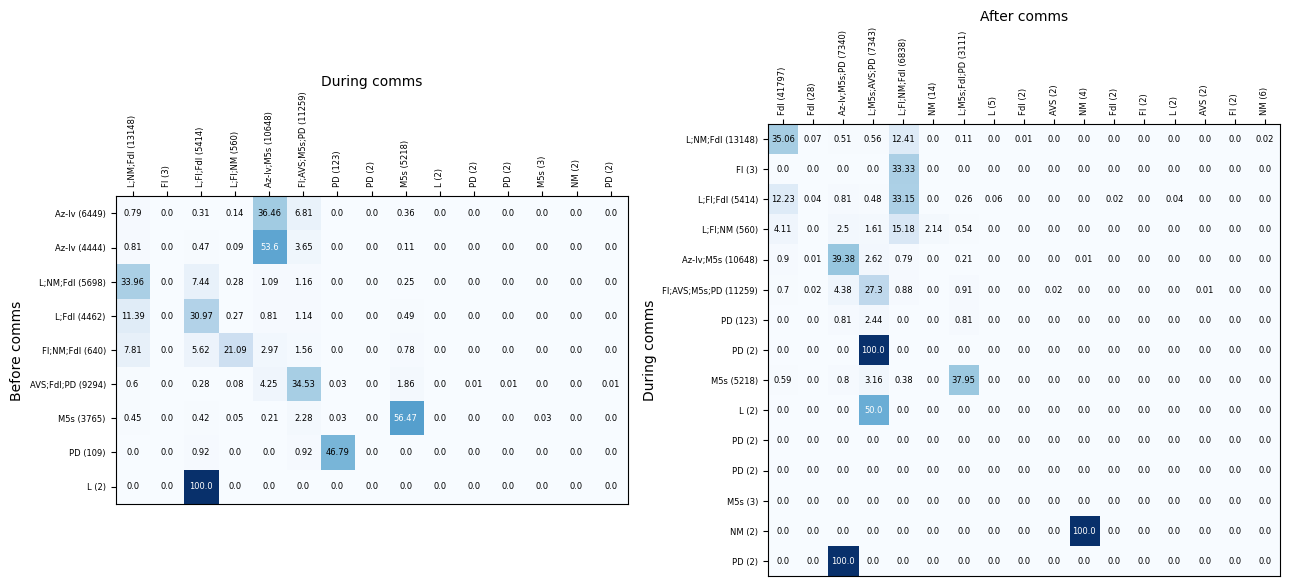

In [41]:
# plot a heatmap of the migration matrix
fig, ax = plt.subplots(1, 2, figsize=(13, 13))

text_colors = {True: 'white', False: 'black'}

im = ax[0].imshow(before_during_migration, cmap='Blues')
im = ax[1].imshow(during_after_migration, cmap='Blues')

# y-labels
ax[0].xaxis.set_label_position('top')
ax[0].set_ylabel('Before comms')
ax[0].set_xlabel('During comms')

ax[1].xaxis.set_label_position('top')
ax[1].set_ylabel('During comms')
ax[1].set_xlabel('After comms')

# Loop over data dimensions and create text annotations.
for i in range(len(before_comms)):
    for j in range(len(during_comms)):
        val = round(before_during_migration[i, j] * 100, 2) 
        text = ax[0].text(j, i, val, ha="center", va="center", size=6, color=text_colors[val > 49])

for i in range(len(during_comms)):
    for j in range(len(after_comms)):
        val1 = round(during_after_migration[i, j] * 100, 2)
        text = ax[1].text(j, i, val1, ha="center", va="center", size=6, color=text_colors[val1 > 49])

# We want to show all ticks...
ax[0].xaxis.tick_top()
ax[0].set_xticks(np.arange(len(during_comms)));
ax[0].set_yticks(np.arange(len(before_comms)));
ax[0].set_xticklabels(during_labels_size, rotation=90, size=6)
ax[0].set_yticklabels(before_labels_size, size=6)

ax[1].xaxis.tick_top()
ax[1].set_yticks(np.arange(len(during_comms)));
ax[1].set_xticks(np.arange(len(after_comms)));
ax[1].set_xticklabels(after_labels_size, rotation=90, size=6)
ax[1].set_yticklabels(during_labels_size, size=6)

fig.tight_layout()


##### Before -> After

#### Representatives migration

##### migration data

In [25]:
representatives_df = pd.read_csv("../../data/raw_data/twitter_representatives_handles_final.csv")
representatives_ids = representatives_df["ids"].values

In [26]:
def find_community(id, comms):
    for index, comm in enumerate(comms):
        if id in comm:
            return index
    return None

In [27]:
representatives_communities = pd.DataFrame(columns=['id', 'period', 'community_id', 'community_label'])

bd_changes = 0
da_changes = 0

for repr in representatives_ids:
    b_comm = find_community(repr, before_comms)
    b_label = get_label(before_community_composition[b_comm]) if b_comm is not None else None
    representatives_communities.loc[len(representatives_communities)] = (repr, 'before', b_comm, b_label)

    d_comm = find_community(repr, during_comms)
    d_label = get_label(during_community_composition[d_comm]) if d_comm is not None else None
    representatives_communities.loc[len(representatives_communities)] = (repr, 'during', d_comm, d_label)

    a_comm = find_community(repr, after_comms)
    a_label = get_label(after_community_composition[a_comm]) if a_comm is not None else None
    representatives_communities.loc[len(representatives_communities)] = (repr, 'after', a_comm, a_label)

    if b_label != d_label:
        bd_changes += 1

    if d_label != a_label:
        da_changes += 1

In [28]:
bd_changes, da_changes

(220, 283)

In [29]:
representatives_communities.dropna(inplace=True)

In [30]:
output_path = f"../../results/{algorithm}_communities/comms_composition/representatives"
representatives_communities.to_csv(os.path.join(output_path, 'representatives_communities.csv'), index=False)

##### Migration matrix

In [31]:
before_during_repr_migration = np.zeros([len(before_comms), len(during_comms)])
during_after_repr_migration = np.zeros([len(during_comms), len(after_comms)])

In [32]:
def find_repr_overlap(comm1, comm2, representatives_ids, normalized=False):
    _comm1 = set(comm1).intersection(set(representatives_ids))
    _comm2 = set(comm2).intersection(set(representatives_ids))

    if normalized:
        return len(set(_comm1).intersection(set(_comm2))) / len(set(_comm1)) #len(set(comm1).union(set(comm2)))

    return len(set(_comm1).intersection(set(_comm2)))

In [33]:
for i, comm1 in enumerate(before_comms):
    for j, comm2 in enumerate(during_comms):
        before_during_repr_migration[i][j] = find_repr_overlap(comm1, comm2, representatives_ids, normalized=True)

In [34]:
for i, comm1 in enumerate(during_comms):
    for j, comm2 in enumerate(after_comms):
        during_after_repr_migration[i][j] = find_repr_overlap(comm1, comm2, representatives_ids, normalized=True)

In [35]:
def expand_label_with_repr_size(label, comm, representatives_ids):
    _comm = set(comm).intersection(set(representatives_ids))
    size = ' (' + str(len(_comm)) + ')'
    return label+size

In [36]:
before_labels_repr_size = [expand_label_with_repr_size(before_labels[i], before_comms[i], representatives_ids) for i in range(0, len(before_comms))]
during_labels_repr_size = [expand_label_with_repr_size(during_labels[i], during_comms[i], representatives_ids) for i in range(0, len(during_comms))]
after_labels_repr_size = [expand_label_with_repr_size(after_labels[i], after_comms[i], representatives_ids) for i in range(0, len(after_comms))]

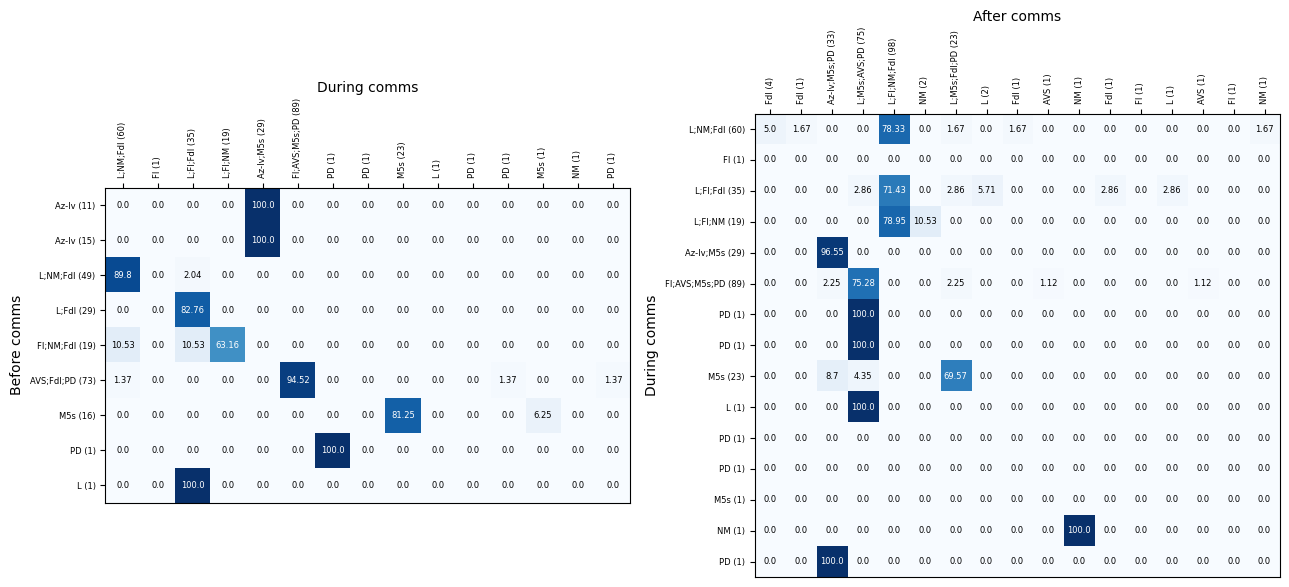

In [45]:
# plot a heatmap of the migration matrix
fig, ax = plt.subplots(1, 2, figsize=(13, 13))

text_colors = {True: 'white', False: 'black'}

im = ax[0].imshow(before_during_repr_migration, cmap='Blues')
im = ax[1].imshow(during_after_repr_migration, cmap='Blues')

# y-labels
ax[0].xaxis.set_label_position('top')
ax[0].set_ylabel('Before comms')
ax[0].set_xlabel('During comms')

ax[1].xaxis.set_label_position('top')
ax[1].set_ylabel('During comms')
ax[1].set_xlabel('After comms')

# Loop over data dimensions and create text annotations.
for i in range(len(before_comms)):
    for j in range(len(during_comms)):
        val = round(before_during_repr_migration[i, j] * 100, 2) 
        text = ax[0].text(j, i, val, ha="center", va="center", size=6, color=text_colors[val > 50])

for i in range(len(during_comms)):
    for j in range(len(after_comms)):
        val1 = round(during_after_repr_migration[i, j] * 100, 2)
        text = ax[1].text(j, i, val1, ha="center", va="center", size=6, color=text_colors[val1 > 50])

# We want to show all ticks...
ax[0].xaxis.tick_top()
ax[0].set_xticks(np.arange(len(during_comms)));
ax[0].set_yticks(np.arange(len(before_comms)));
ax[0].set_xticklabels(during_labels_repr_size, rotation=90, size=6)
ax[0].set_yticklabels(before_labels_repr_size, size=6)

ax[1].xaxis.tick_top()
ax[1].set_yticks(np.arange(len(during_comms)));
ax[1].set_xticks(np.arange(len(after_comms)));
ax[1].set_xticklabels(after_labels_repr_size, rotation=90, size=6)
ax[1].set_yticklabels(during_labels_repr_size, size=6)

fig.tight_layout()
